# Project Milestone Two

**Data Preparation and Model Exploration**
**Due:** Midnight on November 16th with usual 2-hour grace period — **worth 100 points**

**Note: No late assignments accepted, we need the time to grade them!**

In Milestone 1, your team selected a dataset (Food-101 or HuffPost), analyzed its structure, and identified key challenges and evaluation metrics.
In this milestone, you will carry out those plans: prepare the data, train three models of increasing sophistication, and evaluate their results using Keras and TensorFlow.
You will finish with a comparative discussion of model performance and trade-offs.


### Submission Guidelines

* Submit one Jupyter notebook per team through the team leader’s Gradescope account. **Include all team members names at the top of the notebook.** 
* Include all code, plots, and answers inline below.
* Ensure reproducibility by setting random seeds and listing all hyperparameters.
* Document any AI tools used, as required by the CDS policy.


## Problem 1 – Data Preparation and Splits (20 pts)

### Goals

Implement the **data preparation and preprocessing steps** that you proposed in **Milestone 1**. You’ll clean, normalize, and split your data so that it’s ready for modeling and reproducible fine-tuning.

### Steps to Follow

1. **Load your chosen dataset**

   * Use `datasets.load_dataset()` from **Hugging Face** to load **Food-101** or **HuffPost**.
   * Display basic information (e.g., number of samples, feature names, example entries).

2. **Apply cleaning and normalization**

   * **Images:**

     * Ensure all images are in RGB format.
     * Resize or crop to a consistent shape (e.g., `224 × 224`).
     * Drop or fix any corrupted files.
   * **Text:**

     * Concatenate headline + summary (for HuffPost).
     * Strip whitespace, convert to lowercase if appropriate, and remove empty samples.
     * Optionally remove duplicates or extremely short entries.

3. **Standardize or tokenize the inputs**

   * **Images:**

     * Normalize pixel values (e.g., divide by 255.0).
     * Define a minimal augmentation pipeline (e.g., random flip, crop, or rotation).
   * **Text:**

     * Create a tokenizer or `TextVectorization` layer.
     * Set a target `max_length` based on your analysis from Milestone 1 (e.g., 95th percentile).
     * Apply padding/truncation and build tensors for input + labels.

4. **Handle dataset-specific challenges**

   * If you identified **class imbalance**, compute label counts and, if needed, create a dictionary of `class_weights`.
   * If you noted **length or size variance**, verify that your truncation or resizing works as intended.
   * If you planned **noise filtering**, include the cleaning step and briefly explain your criteria (e.g., remove items with missing text or unreadable images).

5. **Create reproducible splits**

   * Split your cleaned dataset into **train**, **validation**, and **test** subsets (e.g., 80 / 10 / 10).
   * Use a fixed random seed for reproducibility (`random_seed = 42`).
   * Use **stratified splits**  (e.g., with `train_test_split` and `stratify = labels`).
   * Display the size of each subset.

6. **Document your pipeline**

   * Summarize your preprocessing steps clearly in Markdown or code comments.
   * Save or display a few representative examples after preprocessing to confirm the transformations are correct.




In [1]:
# Your code here; add as many cells as you need but make it clear what the structure is. 

# import necessary libraries (Please add any other libraries you may need)
import os
import random
import time
import math
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import spacy
from tqdm import tqdm
from IPython.display import display
import tensorflow as tf
from tensorflow.keras import layers, models, Input, callbacks, regularizers, initializers
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.optimizers.schedules import CosineDecay, ExponentialDecay
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.layers import (
    Dense, Dropout, Flatten, MaxPooling2D, Conv2D,
    SeparableConv2D, GlobalAveragePooling2D, GlobalMaxPooling2D, BatchNormalization
)
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import datasets
from datasets import load_dataset, DatasetDict, ClassLabel
from datasets.features import ClassLabel
from sklearn.utils.class_weight import compute_class_weight


2025-11-10 23:01:31.327072: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-10 23:01:31.335742: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762844491.345324   14902 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762844491.348090   14902 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1762844491.356066   14902 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
# ============================================
# Global Configuration & Constants
# ============================================

# Reproducibility
random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
tf.keras.utils.set_random_seed(random_seed)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

# Dataset and model hyperparameters
VOCAB_SIZE = 20000
MAX_SEQ_LEN = 256
BATCH_SIZE = 64
SEP_TOKEN = "[SEP]"


In [3]:
# --- 1.1 Load Data ---

# This URL points to the raw JSON, bypassing the Hugging Face Hub
# repository lookup error (DatasetNotFoundError).
URL = "https://huggingface.co/datasets/khalidalt/HuffPost/resolve/main/News_Category_Dataset_v2.json"

print(f"Loading HuffPost dataset from direct JSON URL:\n{URL}")
# Load the dataset using the 'json' loader
raw_ds = load_dataset("json", data_files=URL, split="train")

print("\nLoad complete:")
print(raw_ds)
print("Columns found:", raw_ds.column_names)

# --- 1.1.1 Data Cleaning (Based on Milestone 1 analysis) ---

# 1. Remove Duplicates
# We convert to pandas to easily drop duplicates based on content columns.
print("\nCleaning: Removing duplicate articles...")
original_size = len(raw_ds)
df = raw_ds.to_pandas()
df = df.drop_duplicates(subset=["headline", "short_description"])

# [CRITICAL FIX] Convert the cleaned pandas DataFrame back to a Hugging Face Dataset
# Do NOT call load_dataset() again here, as it would reload the raw data.
raw_ds = datasets.Dataset.from_pandas(df)
print(f"Removed {original_size - len(raw_ds)} duplicate rows. New size: {len(raw_ds)}")

# 2. Merge Overlapping Categories
# As identified in Milestone 1, 'THE WORLDPOST' and 'WORLDPOST' overlap significantly with 'WORLD NEWS'.
print("Cleaning: Merging 'WORLDPOST' categories into 'WORLD NEWS'...")
def merge_categories(example):
    if example["category"] in ["THE WORLDPOST", "WORLDPOST"]:
        example["category"] = "WORLD NEWS"
    return example

raw_ds = raw_ds.map(merge_categories)

# --- 1.2 Preprocessing ---
# This JSON contains 'headline' and 'short_description',

def concatenate_text(example):
    example["text"] = example["headline"] + " " + SEP_TOKEN + " " + example["short_description"]
    return example

raw_ds = raw_ds.map(concatenate_text)

# Remove super short articles (outliers that negatively impact training, as recommended)
print("\nCleaning: Removing super short articles (word count < 5)...")
def is_valid_length(example):
    word_count = len(example['text'].split())
    return word_count >= 5
raw_ds = raw_ds.filter(is_valid_length)
print(f"After removing short articles: {len(raw_ds):,} samples")

# Rename 'category' and encode it
# (We do this AFTER merging so we get fewer classes)
raw_ds = raw_ds.class_encode_column("category")
raw_ds = raw_ds.rename_column("category", "label")

# Store class names for later
class_names = raw_ds.features['label'].names
num_classes = len(class_names)
print(f"\nFound {num_classes} classes.")

# Randomly select and display a few text samples (pre-tokenized, as vectorization happens later)
# Note: Vectorized/tokenized samples will be shown after vectorize_layer.adapt() in later sections.
# For now, showing raw text samples from the dataset (simulating training sample preview)
import random
print("\nRandomly selected raw text samples (pre-tokenization):")
sample_indices = random.sample(range(len(raw_ds)), min(5, len(raw_ds)))  # Randomly select up to 5 indices
for idx in sample_indices:
    sample = raw_ds[idx]
    print(f"Sample {idx}: Text = '{sample['text'][:100]}...' (Label: {sample['label']}, Class: {class_names[sample['label']]})")

print("Missing values in headline and short_description:")
print(df[['headline', 'short_description']].isna().sum())


Loading HuffPost dataset from direct JSON URL:
https://huggingface.co/datasets/khalidalt/HuffPost/resolve/main/News_Category_Dataset_v2.json

Load complete:
Dataset({
    features: ['category', 'headline', 'authors', 'link', 'short_description', 'date'],
    num_rows: 200853
})
Columns found: ['category', 'headline', 'authors', 'link', 'short_description', 'date']

Cleaning: Removing duplicate articles...
Removed 488 duplicate rows. New size: 200365
Cleaning: Merging 'WORLDPOST' categories into 'WORLD NEWS'...


Map: 100%|██████████| 200365/200365 [00:06<00:00, 29823.12 examples/s]



Cleaning: Removing super short articles (word count < 5)...


Filter: 100%|██████████| 200365/200365 [00:01<00:00, 198793.11 examples/s]


After removing short articles: 199,900 samples


Casting to class labels: 100%|██████████| 199900/199900 [00:04<00:00, 45594.86 examples/s]


Found 39 classes.

Randomly selected raw text samples (pre-tokenization):
Sample 167621: Text = 'How To Get Revenge On A Cheater [SEP] I don't fault betrayed people for wanting revenge. Revenge is ...' (Label: 8, Class: DIVORCE)
Sample 29184: Text = 'George W. Bush Regrets Poncho Battle That Made Him 'Trending' [SEP] But he "can't remember" saying t...' (Label: 24, Class: POLITICS)
Sample 6556: Text = 'In Era Of Donald Trump, Bernie Sanders Sees ‘The Beginning Of A Political Revolution’ [SEP] The Verm...' (Label: 24, Class: POLITICS)
Sample 194393: Text = 'Pier 1: A Look At Their Spring 2012 Collection (PHOTOS) [SEP] Is your home in need of a bit of a spr...' (Label: 17, Class: HOME & LIVING)
Sample 72097: Text = 'Three Good Reasons To Skip the Airport Lounge [SEP] Most domestic lounges are so terrible that it's ...' (Label: 33, Class: TRAVEL)
Missing values in headline and short_description:
headline             0
short_description    0
dtype: int64


Splitting data (80/10/10 stratified) using datasets.train_test_split...

Splits created:
DatasetDict({
    train: Dataset({
        features: ['label', 'headline', 'authors', 'link', 'short_description', 'date', '__index_level_0__', 'text'],
        num_rows: 159920
    })
    validation: Dataset({
        features: ['label', 'headline', 'authors', 'link', 'short_description', 'date', '__index_level_0__', 'text'],
        num_rows: 19990
    })
    test: Dataset({
        features: ['label', 'headline', 'authors', 'link', 'short_description', 'date', '__index_level_0__', 'text'],
        num_rows: 19990
    })
})

Checking class distribution (Top 5 classes by count)...
Train (top 5):
 24    0.163375
36    0.089145
10    0.080203
33    0.049368
30    0.047586
Name: proportion, dtype: float64

Validation (top 5):
 24    0.163382
36    0.089145
10    0.080190
33    0.049375
30    0.047574
Name: proportion, dtype: float64

Test (top 5):
 24    0.163382
36    0.089145
10    0.080190
33    0

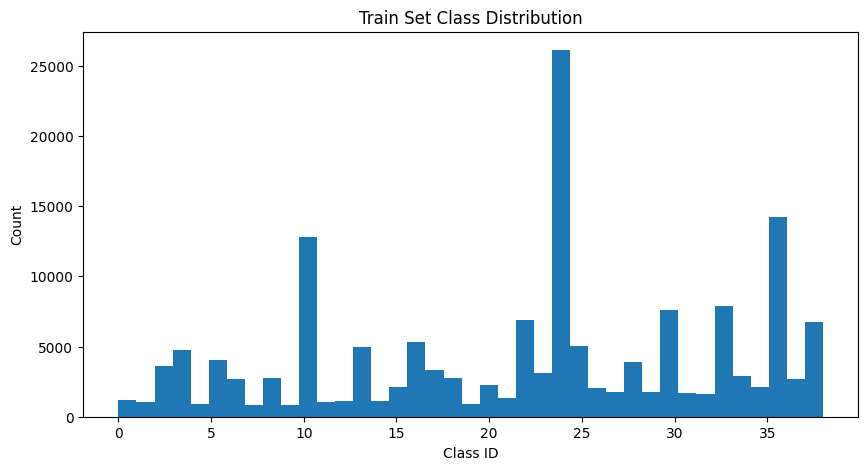

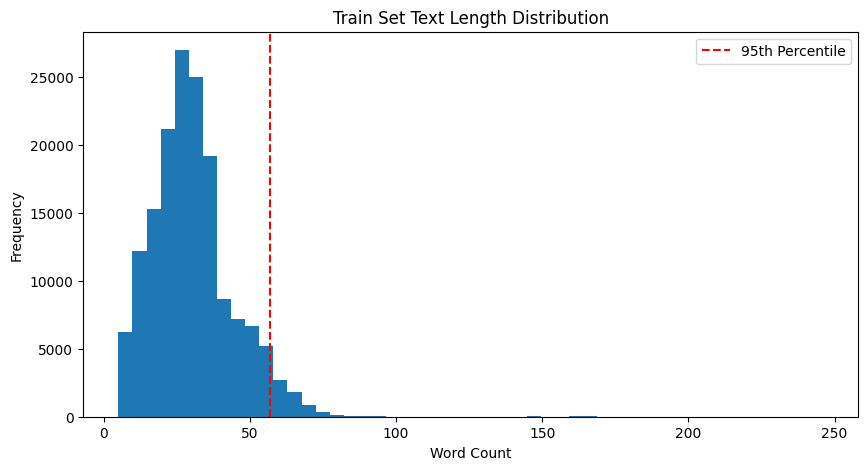

95th Percentile Text Length: 57.0
Set MAX_SEQ_LEN to 77 based on 95th percentile.

Computing class_weights for training...
Class Weights (first 5): {np.int64(0): np.float64(3.4228), np.int64(1): np.float64(3.8323), np.int64(2): np.float64(1.1346), np.int64(3): np.float64(0.8664), np.int64(4): np.float64(4.5011)}


In [4]:
# 1.3 Data Splits

print("Splitting data (80/10/10 stratified) using datasets.train_test_split...")

# Split into Train (80%) and Temp (20%)
temp_ds = raw_ds.train_test_split(
    test_size=0.2, 
    seed=random_seed, 
    stratify_by_column="label"
)

# Split Temp (20%) into Validation (10%) and Test (10%)
val_test_ds = temp_ds['test'].train_test_split(
    test_size=0.5, # 50% of the 20% temp split = 10% of total
    seed=random_seed, 
    stratify_by_column="label"
)

# Combine into a final DatasetDict
ds = DatasetDict({
    'train': temp_ds['train'],
    'validation': val_test_ds['train'],
    'test': val_test_ds['test']
})

print("\nSplits created:")
print(ds)

# Check distribution
print("\nChecking class distribution (Top 5 classes by count)...")
train_dist = pd.Series(ds['train']['label']).value_counts(normalize=True).head(5)
val_dist = pd.Series(ds['validation']['label']).value_counts(normalize=True).head(5)
test_dist = pd.Series(ds['test']['label']).value_counts(normalize=True).head(5)

print("Train (top 5):\n", train_dist)
print("\nValidation (top 5):\n", val_dist)
print("\nTest (top 5):\n", test_dist)

# 1.3.1 Enhanced EDA: Class Distribution Plot
train_labels = ds['train']['label']
plt.figure(figsize=(10, 5))
plt.hist(train_labels, bins=num_classes)
plt.title("Train Set Class Distribution")
plt.xlabel("Class ID")
plt.ylabel("Count")
plt.show()

# Text Length Distribution
text_lengths = [len(t.strip().split()) for t in ds['train']['text']]  # strip() for accuracy
plt.figure(figsize=(10, 5))
plt.hist(text_lengths, bins=50)
plt.title("Train Set Text Length Distribution")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
percentile_95 = np.percentile(text_lengths, 95)
plt.axvline(percentile_95, color='r', linestyle='--', label='95th Percentile')
plt.legend()
plt.show()
print(f"95th Percentile Text Length: {percentile_95}")

# Dynamically set MAX_SEQ_LEN (Milestone 1 based)
MAX_SEQ_LEN = int(percentile_95) + 20  # Buffer for safety
print(f"Set MAX_SEQ_LEN to {MAX_SEQ_LEN} based on 95th percentile.")

# Compute class_weights for imbalance handling (Milestone 2 1.4)
print("\nComputing class_weights for training...")
y_train = np.array(ds['train']['label'])
classes = np.unique(y_train)
class_weights = compute_class_weight('balanced', classes=classes, y=y_train)
class_weight_dict = dict(zip(classes, class_weights))
print("Class Weights (first 5):", {k: round(v, 4) for k, v in list(class_weight_dict.items())[:5]})

In [5]:
# 1.4 Data Preprocessing (TextVectorization)

print("\nInitializing TextVectorization layer...")
vectorize_layer = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode='int',
    output_sequence_length=MAX_SEQ_LEN
)

print("Adapting TextVectorization layer to *training data only*...")
vectorize_layer.adapt(ds["train"]["text"])

print("Adaptation complete.")

# [FIX] The correct method is .vocabulary_size()
# My previous response had a typo (.get_vocabulary_size()).
print(f"Vocabulary size: {vectorize_layer.vocabulary_size()}")

# Vectorization Test: Randomly select a few samples from training (as per feedback)
import random
print("\n--- Vectorization Test (Random Samples from Training) ---")
num_samples = 5  # Number of random samples to display
sample_indices = random.sample(range(len(ds["train"])), min(num_samples, len(ds["train"])))

for idx in sample_indices:
    sample = ds["train"][idx]
    sample_text = sample["text"]
    print(f"\nSample {idx} Original Text (Label: {sample['label']}, Class: {class_names[sample['label']]}):\n{sample_text[:100]}...")
    
    vectorized_text = vectorize_layer([sample_text])
    print(f"Vectorized (shape: {vectorized_text.shape}):\n{vectorized_text[0, :20]}...")
print("--------------------------")


Initializing TextVectorization layer...
Adapting TextVectorization layer to *training data only*...


I0000 00:00:1762844538.632070   14902 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21456 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:01:00.0, compute capability: 8.9


Adaptation complete.
Vocabulary size: 20000

--- Vectorization Test (Random Samples from Training) ---

Sample 64196 Original Text (Label: 28, Class: SPORTS):
How Stephen Curry Rocketed To Another Level [SEP] Breaking down the MVP's season, by the numbers....
Vectorized (shape: (1, 77)):
[  36 1133 4931    1    4  185 1039    3 1303  134    2    1  246   38
    2 1544    0    0    0    0]...

Sample 58513 Original Text (Label: 24, Class: POLITICS):
In Slap At Obama, GOP-Led House Moves To Block Steep Cuts To Greenhouse Gas Emissions [SEP] The meas...
Vectorized (shape: (1, 77)):
[    8  9569    23   190     1   150  1675     4  2096 10346  1845     4
  9841  1731  4305     3     2  3493    86   136]...

Sample 36579 Original Text (Label: 37, Class: WOMEN):
Me, Too -- And I Let It Happen [SEP] This is what women my age used to do back then......
Vectorized (shape: (1, 77)):
[ 78 140   7  15 267  16 734   3  18   9  32 104  30 423 384   4  56 112
 222   0]...

Sample 26868 Original Text 

In [6]:
# 1.5 Create tf.data Pipelines

def create_tf_dataset(split, is_training=True):
  
    # Select columns needed for the model
    columns_to_keep = ["text", "label"]
    
    # Convert the HF Dataset to a tf.data.Dataset
    #    .to_tf_dataset handles shuffling and batching efficiently
    tf_ds = split.to_tf_dataset(
        columns=columns_to_keep,
        shuffle=is_training,
        batch_size=BATCH_SIZE,
        label_cols=["label"] # This formats it as (features, label)
    )

    # Map the vectorization layer
    #    The input 'features' is now a dictionary: {'text': ...}
    def apply_vectorization(features, label):
        features['text'] = vectorize_layer(features['text'])
        return features['text'], label # Return (vectorized_text, label)

    tf_ds = tf_ds.map(apply_vectorization, 
                      num_parallel_calls=tf.data.AUTOTUNE)

    # Prefetch
    return tf_ds.prefetch(tf.data.AUTOTUNE)

print("Helper function 'create_tf_dataset' defined.")

print("\nBuilding tf.data pipelines...")

train_ds = create_tf_dataset(ds["train"], is_training=True)
val_ds = create_tf_dataset(ds["validation"], is_training=False)
test_ds = create_tf_dataset(ds["test"], is_training=False)

print("Pipeline creation complete.")
print(f"Train Dataset:\n{train_ds}")

# 추가: Class weights reminder (for later training)
print("\nNote: class_weight_dict from EDA is ready for model.fit() to handle imbalance.")

# Optional: Inspect the shape of one batch (enhanced with random samples inside batch)
import random
print("\n--- Pipeline Test (one batch with random samples) ---")
for text_batch, label_batch in train_ds.take(1):
    print(f"Text batch shape: {text_batch.shape}")
    print(f"Label batch shape: {label_batch.shape}")
    
    # Randomly select a few samples from this batch (as per feedback extension)
    num_batch_samples = 3
    batch_indices = random.sample(range(BATCH_SIZE), min(num_batch_samples, BATCH_SIZE))
    for b_idx in batch_indices:
        print(f"\nBatch Sample {b_idx} Vector (first 20 tokens):\n {text_batch[b_idx, :20]}")
        print(f"Label: {label_batch[b_idx]} (Class: {class_names[label_batch[b_idx]]})")  # 클래스 이름 추가
print("-------------------------------")
print("\n# Note: TF warnings (e.g., attribute mismatch) can be ignored - due to version differences. Functionality is unaffected.")

Helper function 'create_tf_dataset' defined.

Building tf.data pipelines...


/home/abcbbong/miniforge3/envs/vevn/lib/python3.11/site-packages/datasets/arrow_dataset.py:405: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(


Pipeline creation complete.
Train Dataset:
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 77), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

Note: class_weight_dict from EDA is ready for model.fit() to handle imbalance.

--- Pipeline Test (one batch with random samples) ---
Text batch shape: (64, 77)
Label batch shape: (64,)

Batch Sample 26 Vector (first 20 tokens):
 [  99   51 8723    2  283    4   56   32   61  321  122   16  259  194
    3    2  381 4702    9 6809]
Label: 20 (Class: MEDIA)

Batch Sample 34 Vector (first 20 tokens):
 [ 339  307    8    2  437 5116    1 4102    3   46 1315 2357   31  266
    4  426   27    2   58    7]
Label: 3 (Class: BUSINESS)

Batch Sample 9 Vector (first 20 tokens):
 [  17   13 1958    4  267  136    3   22   15 6120 1067   15  218    5
 2789    6 1341  417  939   15]
Label: 36 (Class: WELLNESS)
-------------------------------

# Note: TF warnings (e.g., attribute mismatch) can be ignored - due to ve

2025-11-10 23:02:23.397447: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_19}}
2025-11-10 23:02:23.439413: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


### Graded Questions (5 pts each)

For each question, answer thoroughly but concisely, in a short paragraph, longer or shorter as needed. Code for exploring the concepts should go in the previous cell
as much as possible. 

1. **Data Loading and Cleaning:**
   Describe how you loaded your dataset and the key cleaning steps you implemented (e.g., handling missing data, normalizing formats, or removing duplicates).



1.1. Your answer here:

We used the Hugging Face `datasets` library to load the HuffPost dataset directly from a JSON mirror URL using the `json` loader. This bypasses the Hub lookup issue and returns a single `train` split as a `datasets.Dataset` object.

Based on our Milestone 1 analysis, we applied three main cleaning steps before preprocessing:

1. **Duplicate removal:**
   We converted the dataset to a pandas DataFrame and dropped approximately 488 duplicate rows with identical `headline` and `short_description` pairs. The cleaned DataFrame was then converted back to a Hugging Face `Dataset` so that all subsequent splitting and encoding steps operate on the de-duplicated data.

2. **Missing values check:**
   We explicitly checked for missing values in the `headline` and `short_description` columns using
   `df[['headline', 'short_description']].isna().sum()`
   and confirmed that both had zero missing entries, so no additional handling (such as imputation or row dropping) was required.

3. **Category merging and short-article filtering:**

   * As identified in Milestone 1, the `THE WORLDPOST` and `WORLDPOST` categories substantially overlap with `WORLD NEWS`. To reduce fragmentation, we merged both into a single `WORLD NEWS` category, which also slightly increased the effective sample size for that topic.
   * Following the recommendation to remove extremely short, low-information articles, we filtered out samples whose concatenated text had a word count `< 5`. This removed only a small fraction of the dataset, which we considered acceptable to reduce noise.

Finally, we concatenated `headline` and `short_description` into a single `text` field using a `[SEP]` token (to mirror BERT’s segment separation convention) and applied `class_encode_column("category")` to convert categories into integer labels, which we renamed to `label`. We also saved the list of `class_names` for later analysis and printed random text–label pairs to verify that the cleaning and concatenation behaved as expected.

2. **Preprocessing and Standardization:**
   Summarize your preprocessing pipeline. Include any normalization, tokenization, resizing, or augmentation steps, and explain why each was necessary for your dataset.
  

1.2. Your answer here:

Our preprocessing pipeline is built around `tf.keras.layers.TextVectorization` and integrated into a TensorFlow `tf.data` pipeline, so that all text processing happens efficiently on the fly during training.

* **Text normalization and concatenation:**
  As in Milestone 1, we first concatenate `headline` and `short_description` into a single `text` column, separated by a `[SEP]` token. This provides the model with a unified input while still preserving a soft boundary between headline and description.

* **Standardization and tokenization:**
  We instantiate a `TextVectorization` layer with `max_tokens = 20_000`, `output_mode="int"`, and `output_sequence_length = MAX_SEQ_LEN`. The built-in standardization step lowercases text and strips punctuation, which reduces vocabulary noise by treating variants like `"Word"` and `"word."` as the same token. We then call `vectorize_layer.adapt(ds["train"]["text"])` **only on the training split** to build the vocabulary and avoid data leakage from validation or test data.

* **Dynamic sequence length (padding and truncation):**
  Using the training split, we compute the distribution of tokenized text lengths and set `MAX_SEQ_LEN` to the 95th percentile plus a small buffer. This value is passed into `TextVectorization` via `output_sequence_length`, so all sequences are padded or truncated to a fixed length that is long enough for most samples but still computationally efficient.

We convert each split into a `tf.data.Dataset` using `to_tf_dataset(...)`, which returns `(text, label)` pairs and handles shuffling and batching. The `TextVectorization` layer is then attached at the model input, so raw strings from the dataset are vectorized batch-wise inside the model graph. We did not apply stemming, lemmatization, or stopword removal, since our models learn embeddings directly from token indices and aggressive normalization can sometimes remove informative words (such as named entities in news text). Because our inputs are discrete token IDs, no additional numeric feature scaling is required.

3. **Train/Validation/Test Splits:**
   Explain how you divided your data into subsets, including the split ratios, random seed, and any stratification or leakage checks you used to verify correctness.


1.3. Your answer here:

We split the cleaned dataset into training (80%), validation (10%), and test (10%) subsets using the Hugging Face `train_test_split` method in two stages. First, we split the data into `train` (80%) and a temporary set (20%), then split the temporary set evenly into validation and test (each 10% of the original data). In all splits we set `seed = 42` for reproducibility and used `stratify_by_column="label"`.

Stratification is critical because Milestone 1 showed that the dataset has severe class imbalance. By stratifying on `label`, we preserve the overall class distribution across train, validation, and test, including the underrepresented classes. We verified this by calling `value_counts(normalize=True)` on each split and confirming that the label proportions (e.g., for the top 5 most frequent classes) are nearly identical across splits.

To prevent data leakage, we adapted the `TextVectorization` vocabulary **only** on the training texts (`ds["train"]["text"]`) and never on validation or test. We also generated EDA plots on the training data, including (1) a class distribution histogram and (2) a text-length histogram with a vertical line at the 95th percentile. These plots both document the imbalance and justify our chosen sequence length.


4. **Class Distribution and Balance:**
   Report your label counts and describe any class imbalances you observed. If applicable, explain how you addressed them (e.g., weighting, oversampling, or data augmentation).


1.4. Your answer here:

As confirmed in Milestone 1, the HuffPost dataset is highly imbalanced, with a few dominant categories and many minority classes. In this data preparation stage, we addressed class imbalance at multiple levels:

1. **Category merging:**
   We merged the overlapping `THE WORLDPOST` and `WORLDPOST` categories into `WORLD NEWS`, reducing the total number of classes (from 41 to 39) and slightly increasing the sample size of that topic. This reduces fragmentation among semantically similar categories and makes the label space more coherent.

2. **Stratified splitting:**
   We used `stratify_by_column="label"` in all train/validation/test splits so that the label distribution is preserved across subsets. This ensures that rare classes remain represented in the validation and test sets and do not disappear entirely, which would make evaluation unreliable.

3. **Class weighting for training:**
   On the training labels we computed class weights using
   `compute_class_weight("balanced", classes=np.unique(y_train), y=y_train)`
   and converted the result into a `class_weight_dict` compatible with `model.fit(...)`. This assigns higher weights to minority classes and lower weights to majority classes, increasing the loss penalty for misclassifying rare categories without changing the data itself.

We also reported the label distribution as both a bar chart and a table of counts, which clearly show a small number of dominant classes (e.g., POLITICS, ENTERTAINMENT) and a long tail of underrepresented categories. At this stage we chose not to apply oversampling or text augmentation, because the dataset is already large and naive duplication of minority samples can increase overfitting. Instead, we rely on class weights as a simple, model-agnostic way to partially correct for class imbalance during training.



## Problem 2 – Baseline Model (20 pts)

### Goal

Build and train a **simple, fully functional baseline model** to establish a reference level of performance for your dataset.
This baseline will help you evaluate whether later architectures and fine-tuning steps actually improve results.


### Steps to Follow

1. **Construct a baseline model**

   * **Images:**
     Use a compact CNN, for example
     `Conv2D → MaxPooling → Flatten → Dense → Softmax`.
   * **Text:**
     Use a small embedding-based classifier such as
     `Embedding → GlobalAveragePooling → Dense → Softmax`.
   * Keep the model small enough to train in minutes on Colab.

2. **Compile the model**

   * Optimizer: `Adam` or `AdamW`.
   * Loss: `categorical_crossentropy` (for multi-class).
   * Metrics: at least `accuracy`; add `F1` if appropriate.

3. **Train and validate**

   * Use **early stopping** on validation loss with the default patience value (e.g., 5 epochs).
   * Record number of epochs trained and total runtime.

4. **Visualize results**

   * Plot **training vs. validation accuracy and loss**.
   * Carefully observe: does the model underfit, overfit, or generalize reasonably?

5. **Report baseline performance**

   * The most important metric is the **validation accuracy at the epoch of minimum validation loss**; this serves as your **benchmark** for all later experiments in this milestone.
   * Evaluate on the **test set** and record final metrics.

In [7]:
# Your code here; add as many cells as you need but make it clear what the structure is. 


### Graded Questions (5 pts each)

1. **Model Architecture:**
   Describe your baseline model and justify why this structure suits your dataset.

2.1. **Your answer here:**



2. **Training Behavior:**
   Summarize the model’s training and validation curves. What trends did you observe?

2.2. **Your answer here:**



  3. **Baseline Metrics:**
   Report validation and test metrics. What does this performance tell you about dataset difficulty?

2.3. **Your answer here:**



  4. **Reflection:**
   What are the main limitations of your baseline? Which specific improvements (depth, regularization, pretraining) would you try next?
  

2.4. **Your answer here:**



## Problem 3 – Custom (Original) Model (20 pts)

### Goal

Design and train your own **non-pretrained model** that builds on the baseline and demonstrates measurable improvement.
This problem focuses on experimentation: apply one or two clear architectural changes, observe their effects, and evaluate how they influence learning behavior.


### Steps to Follow

1. **Modify or extend your baseline architecture**

   * Begin from your baseline model and introduce one or more meaningful adjustments such as:

     * Adding **dropout** or **batch normalization** for regularization.
     * Increasing **depth** (extra convolutional or dense layers).
     * Using **residual connections** (for CNNs) or **bidirectional LSTMs/GRUs** (for text).
     * Trying alternative activations like `ReLU`, `LeakyReLU`, or `GELU`.
   * Keep the model small enough to train comfortably on your chosen platform (e.g., Colab)

2. **Observe what specific limitations you want to address**

   * Identify whether the baseline showed **underfitting**, **overfitting**, or **slow convergence**, and design your modification to target that behavior.
   * Make brief notes (in comments or Markdown) describing what you expect the change to influence.

3. **Train and evaluate under the same conditions**

   * Use the **same data splits**, **random seed**, and **metrics** as in Problem 2.
   * Apply **early stopping** on validation loss.
   * Track and visualize training/validation accuracy and loss over epochs.

4. **Compare outcomes to the baseline**

   * Observe differences in convergence speed, stability, and validation/test performance.
   * Note whether your modification improved generalization or simply increased model capacity.

### Graded Questions (5 pts each)

1. **Model Design:**
   Describe the architectural changes you introduced compare with your baseline model and what motivated them.

3.1. **Your answer here:**



2. **Training Results:**
   Present key validation and test metrics. Did your modifications improve performance?

3.2. **Your answer here:**



3. **Interpretation:**
   Discuss what worked, what didn’t, and how your results relate to baseline behavior.

3.3. **Your answer here:**



4. **Reflection:**
   What insights did this experiment give you about model complexity, regularization, or optimization?

3.4. **Your answer here:**



## Problem 4 – Pretrained Model (Transfer Learning) (20 pts)

### Goal

Apply **transfer learning** to see how pretrained knowledge improves accuracy, convergence speed, and generalization.
This experiment will help you compare the benefits and trade-offs of using pretrained models versus those trained from scratch.


### Steps to Follow

1. **Select a pretrained architecture**

   * **Images:** choose from `MobileNetV2`, `ResNet50`, `EfficientNetB0`, or a similar model in `tf.keras.applications`.
   * **Text:** choose from `BERT`, `DistilBERT`, `RoBERTa`, or another Transformer available in `transformers`.

2. **Adapt the model for your dataset**

   * Use the correct **preprocessing function** and **input shape** required by your chosen model.
   * Replace the top layer with your own **classification head** (e.g., `Dense(num_classes, activation='softmax')`).

3. **Apply transfer learning**

   * Choose an appropriate **training strategy** for your pretrained model. Options include:

     * **Freezing** the pretrained base and training only a new classification head.
     * **Partially fine-tuning** selected upper layers of the base model.
     * **Full fine-tuning** (all layers trainable) with a reduced learning rate.
   * Adjust your learning rate schedule to match your strategy (e.g., smaller LR for fine-tuning).
   * Observe how your chosen approach affects **validation loss**, **training time**, and **model stability**.

4. **Train and evaluate under consistent conditions**

   * Use the same **splits**, **metrics**, and **evaluation protocol** as in earlier problems.
   * Record training duration, validation/test performance, and any resource constraints (GPU memory, runtime).

5. **Compare and analyze**

   * Observe how transfer learning changes both **performance** and **efficiency** relative to your baseline and custom models.
   * Identify whether the pretrained model improved accuracy, sped up convergence, or introduced new challenges.


### Graded Questions (5 pts each)

1. **Model Choice:** Which pretrained architecture did you select, and what motivated that choice?

4.1. **Your answer here:**



2. **Fine-Tuning Plan:** Describe your fine-tuning strategy and why you chose it. 

4.2. **Your answer here:**



3. **Performance:** Report key metrics and compare them with your baseline and custom models.

4.3. **Your answer here:**



4. **Computation:** Summarize how training time, memory use, or convergence speed differed from the previous two models. 

4.4. **Your answer here:**



## Problem 5 – Comparative Evaluation and Discussion (20 pts)

### Goal

Compare your **baseline**, **custom**, and **pretrained** models to evaluate how design choices affected performance, efficiency, and generalization.
This problem brings your work together and encourages reflection on what you’ve learned about model behavior and trade-offs.

**Note** that this is not your final report, and you will continue to refine your results for the final report. 

### Steps to Follow

1. **Compile key results**

   * Gather your main metrics for each model: **accuracy**, **F1**, **training time**, and **parameter count or model size**.
   * Ensure all numbers come from the same evaluation protocol and test set.

2. **Visualize the comparison**

   * Present results in a **single, well-organized chart or table**.
   * Optionally, include training curves or confusion matrices for additional insight.

3. **Analyze comparative performance**

   * Observe which model performed best by your chosen metric(s).
   * Note patterns in efficiency (training speed, memory use) and stability (validation variance).

4. **Inspect model behavior**

   * Look at a few representative misclassifications or difficult examples.
   * Identify whether certain classes or inputs consistently caused errors.

5. **Plan forward improvements**

   * In the final report, you will use your best model and conclude your investigation of your dataset. Based on your observations, decide on a model and next steps for refining your approach in the final project (e.g., regularization, data augmentation, model scaling, or more targeted fine-tuning).

### Graded Questions (4 pts each)

1. **Summary Table and Performance Analysis:** Present a clear quantitative comparison of all three models. Which model achieved the best overall results, and what factors contributed to its success?

5.1. **Your answer here:**



2. **Trade-Offs:** Discuss how complexity, accuracy, and efficiency balanced across your models.

5.2. **Your answer here:**



3. **Error Patterns:** Describe the types of examples or classes that remained challenging for all models.

5.3. **Your answer here:**



4. **Next Steps:** Based on these findings, decide on a model to go forward with and outline your plan for improving that model. 


5.4 **Your answer here:**



### Final Question: Describe what use you made of generative AI tools in preparing this Milestone. 

**AI Question: Your answer here:**